<a href="https://colab.research.google.com/github/Grumpy-Kitten/ntu-msis-data-mining/blob/assignment-1/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variant 2

In this variant, you will compare **two** existing implementations of classifiers. You can choose any two existing implementations of **classification models**. Train and test them on the dataset provided in the beginning. **Compare** the two models using techniques for classification model comparison.

*==> Task divided:*

1. Data Preprocessing & Feature engineering
2. Train two exisiting implementations of classification models
3. Test the models
4. Hyperparameter Tuning
5. Comparing the models using techniques

*==> My model choices:*

1. Random Forest Classification
2. Naive Bayes

###1 Data Preprocessing


In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
current_path = "/content/drive/MyDrive/Study/NTU WKWSCI MSIS/Data Mining/Assignments/Assignment 1/Census Income Data Set/"
features = ['Age', 'Workclass', 'Fnlwgt', 'Education', 'Education_Num', 'Marital_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Capital_Gain', 'Capital_Loss', 'Hours_Per_Week', 'Native_Country', 'Class']

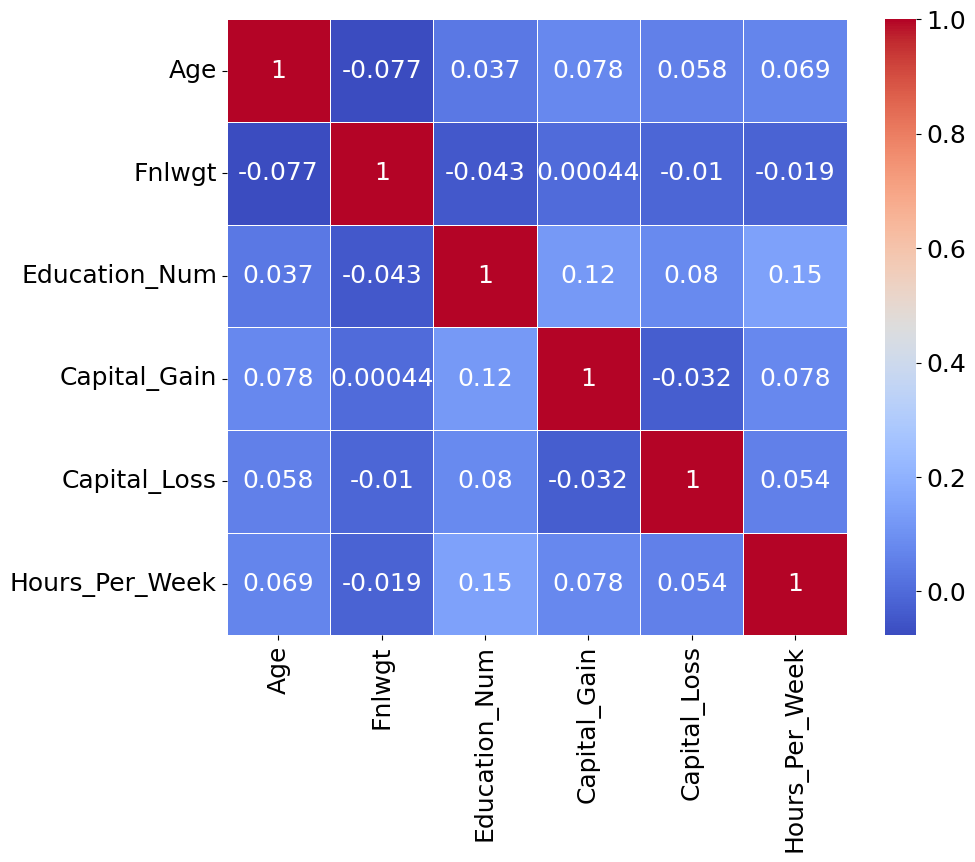

,Age,Workclass,Fnlwgt,Education,Education_Num,Marital_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_Per_Week,Native_Country,Class
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [2]:
train_data = pd.read_csv(current_path+"adult.data")
train_data.columns = features

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

# Create pair plots to visualize feature relationships
# sns.pairplot(train_data, hue='Class')
# plt.show()

# Correlation Heatmap
def plot_correlation_heatmap(df):
  correlation_matrix = df.corr()
  plt.figure(figsize=(10, 8))
  sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
  plt.show()

plot_correlation_heatmap(train_data)

import matplotlib.pyplot as plt
import seaborn as sns

def fancy_plot(df, bins=None):
    """
    Customized function to visualize the distribution of all columns in a DataFrame.

    Parameters:
    - df: DataFrame containing the data to be plotted.
    - bins: Number of bins for histograms (default is None, suitable for categorical data).
    """
    # Determine the number of rows and columns for subplots
    num_cols = df.shape[1]
    num_rows = (num_cols + 1) // 2  # Create two columns of subplots

    # Create a figure and axis for subplots
    fig, axes = plt.subplots(num_rows, 2, figsize=(15, num_rows * 5))

    # Flatten the axes for easier iteration
    axes = axes.flatten()

    # Iterate through columns and create plots
    for i, column_name in enumerate(df.columns):
        ax = axes[i]

        if df[column_name].dtype == 'int64' or df[column_name].dtype == 'float64':
            # Plot a histogram for numeric columns
            _, bins, patches = ax.hist(df[column_name], bins=bins, color='#86bf91', alpha=0.7)
            ax.set_title(f'Distribution of {column_name}', fontsize=14)
            ax.set_xlabel(column_name, fontsize=12)
            ax.set_ylabel('Frequency', fontsize=12)
            ax.grid(axis='y', linestyle='--', alpha=0.7)
            ax.axhline(y=0, color='black', linewidth=0.8)
            ax.set_xticks(bins)
        else:
            # Plot a bar chart for categorical columns
            value_counts = df[column_name].value_counts()
            value_counts.plot(kind='bar', color='#86bf91', ax=ax)
            ax.set_title(f'Distribution of {column_name}', fontsize=14)
            ax.set_xlabel(column_name, fontsize=12)
            ax.set_ylabel('Frequency', fontsize=12)
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

    # Remove any unused subplots
    for i in range(len(df.columns), num_cols):
        fig.delaxes(axes[i])

    # Adjust layout
    plt.tight_layout()

    # Show plots
    plt.show()

# fancy_plot(train_data)

# train_data.info()
train_data.head()

In [3]:
test_data = pd.read_csv(current_path+"adult.test").reset_index()
test_data.columns = features
# test_data.head()

**1.1 Handling missing values**

In [4]:
# Check if there is NaN values
train_num_nans = train_data.isnull().sum()
test_num_nans = test_data.isnull().sum()
print ("The number of NaNs in the training data is:", train_num_nans)
print ("The number of NaNs in the testing data is:", train_num_nans)

# If NaN exists:
# Replace NaN values in all columns with the median of each respective column
# train_data = train_data.fillna(train_data.median())
# test_data = test_data.fillna(test_data.median())

The number of NaNs in the training data is: Age               0
Workclass         0
Fnlwgt            0
Education         0
Education_Num     0
Marital_Status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital_Gain      0
Capital_Loss      0
Hours_Per_Week    0
Native_Country    0
Class             0
dtype: int64
The number of NaNs in the testing data is: Age               0
Workclass         0
Fnlwgt            0
Education         0
Education_Num     0
Marital_Status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital_Gain      0
Capital_Loss      0
Hours_Per_Week    0
Native_Country    0
Class             0
dtype: int64


In [5]:
# To replace value "?" with the median of each respective column
import numpy as np

def remove_question_mark(df):
  # Identify columns containing "?"
  columns_with_question_mark = df.columns[df.isin(['?']).any()]

  # Calculate the median value for each of those columns
  medians = df[columns_with_question_mark].replace('?', np.nan).median()

  # Replace "?" values with medians in the identified columns
  df[columns_with_question_mark] = df[columns_with_question_mark].replace('?', medians)

  return df

train_data = remove_question_mark(train_data)
test_data = remove_question_mark(test_data)

# Check if the "?" still exist
train_columns_with_question_mark = train_data.columns[train_data.isin(['?']).any()]
test_columns_with_question_mark = train_data.columns[test_data.isin(['?']).any()]
print (train_columns_with_question_mark, test_columns_with_question_mark)

Index([], dtype='object') Index([], dtype='object')


**1.2 Label encoding**

In [6]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

def label_encoding(df):
  # Apply label encoding to all object-type columns
  object_columns = df.select_dtypes(include=['object']).columns

  for col in object_columns:
      df[col] = label_encoder.fit_transform(df[col])

  return df

train_data = label_encoding(train_data)
test_data = label_encoding(test_data)

train_data.head()

,Age,Workclass,Fnlwgt,Education,Education_Num,Marital_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_Per_Week,Native_Country,Class
0,50,6,83311,9,13,2,4,0,4,1,0,0,13,39,0
1,38,4,215646,11,9,0,6,1,4,1,0,0,40,39,0
2,53,4,234721,1,7,2,6,0,2,1,0,0,40,39,0
3,28,4,338409,9,13,2,10,5,2,0,0,0,40,5,0
4,37,4,284582,12,14,2,4,5,4,0,0,0,40,39,0


**1.3 Observe imbalance**

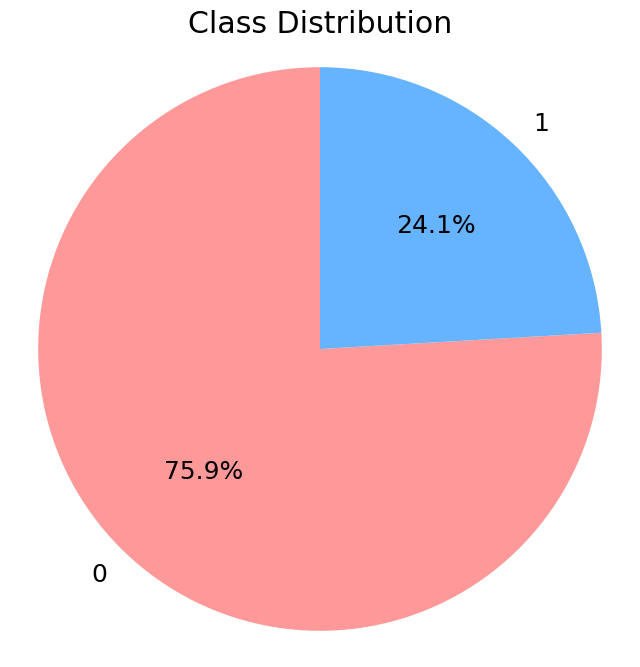

In [7]:
# As shown by the visualization of target variable we can see the ratio is imbalanced

def plot_balance(df):
  class_counts = df['Class'].value_counts()

  # Create a pie chart to visualize the class distribution
  plt.figure(figsize=(8, 8))
  colors = ['#ff9999', '#66b3ff']
  plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
  plt.title('Class Distribution')
  plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

  plt.show()

# train_data['Class'].value_counts().plot(kind='bar')
plot_balance(train_data)

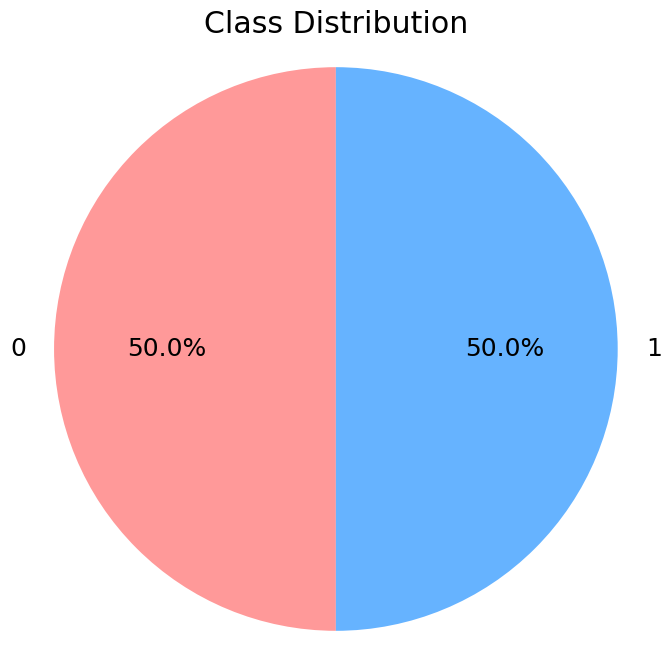

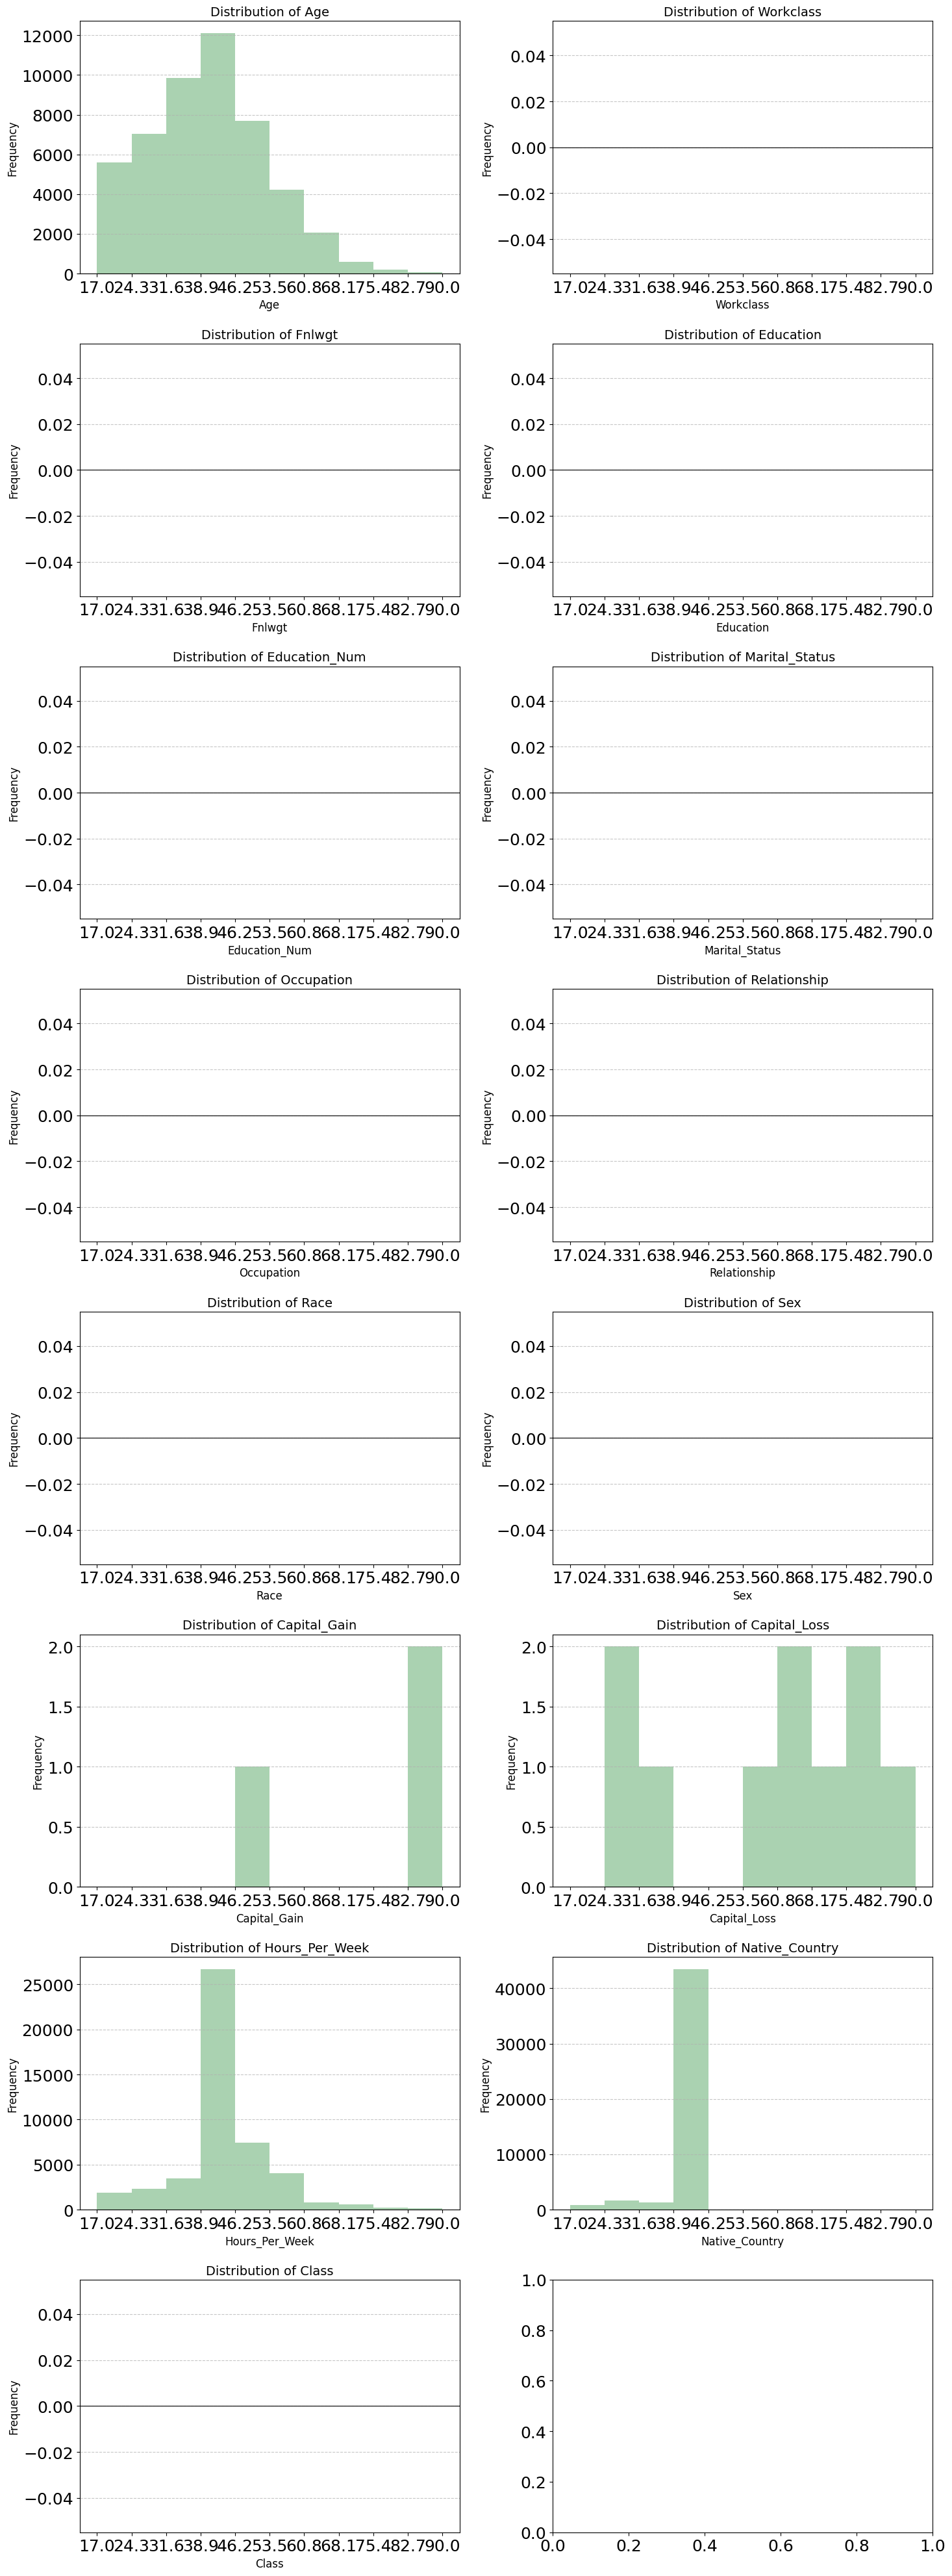

In [8]:
from imblearn.over_sampling import SMOTE

def oversample(df):
  # Separate the features (X) and target variable (y)
  X = df.drop(columns=['Class'])
  y = df['Class']

  # Initialize the SMOTE object
  smote = SMOTE(sampling_strategy='auto', random_state=42)

  # Apply SMOTE to generate synthetic samples
  X_resampled, y_resampled = smote.fit_resample(X, y)

  # Create a new DataFrame with resampled data
  resampled_df = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name='Class')], axis=1)

  return resampled_df

train_data = oversample(train_data)

# Check the balance of oversampled data
# train_data['Class'].value_counts().plot(kind='bar')
plot_balance(train_data)

# plot_correlation_heatmap(train_data)
fancy_plot(train_data)

**Milestone:**
successfully handled missing values, performed label encoding on the categorical columns, and resampled the dataset into a balanced one. The DataFrame now has all numeric data types, which is suitable for many machine learning algorithms.

### 2 Model Training & Testing

**2.1 Random Forest Classification**

In [9]:
from sklearn.ensemble import RandomForestClassifier
import time

X_train = train_data.drop(columns=['Class'])
y_train = train_data['Class']

X_test = test_data.drop(columns=['Class'])
y_test = test_data['Class']

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Record the start time
start_time = time.time()

# Train the model on the training data
rf_classifier.fit(X_train, y_train)

# Record the end time
end_time = time.time()

# Calculate the training time in seconds
training_time = end_time - start_time

# Print the training time
print(f"Training time of Random Forest Classifier: {training_time:.2f} seconds")

# Make predictions on the test data
rf_predictions = rf_classifier.predict(X_test)

Training time of Random Forest Classifier: 14.61 seconds


[0.14039925 0.03384408 0.1073425  0.07695388 0.08494307 0.17212921
 0.05688285 0.10939894 0.01083992 0.01132427 0.06547276 0.01856708
 0.09744385 0.01445832] Index(['Age', 'Workclass', 'Fnlwgt', 'Education', 'Education_Num',
       'Marital_Status', 'Occupation', 'Relationship', 'Race', 'Sex',
       'Capital_Gain', 'Capital_Loss', 'Hours_Per_Week', 'Native_Country'],
      dtype='object')


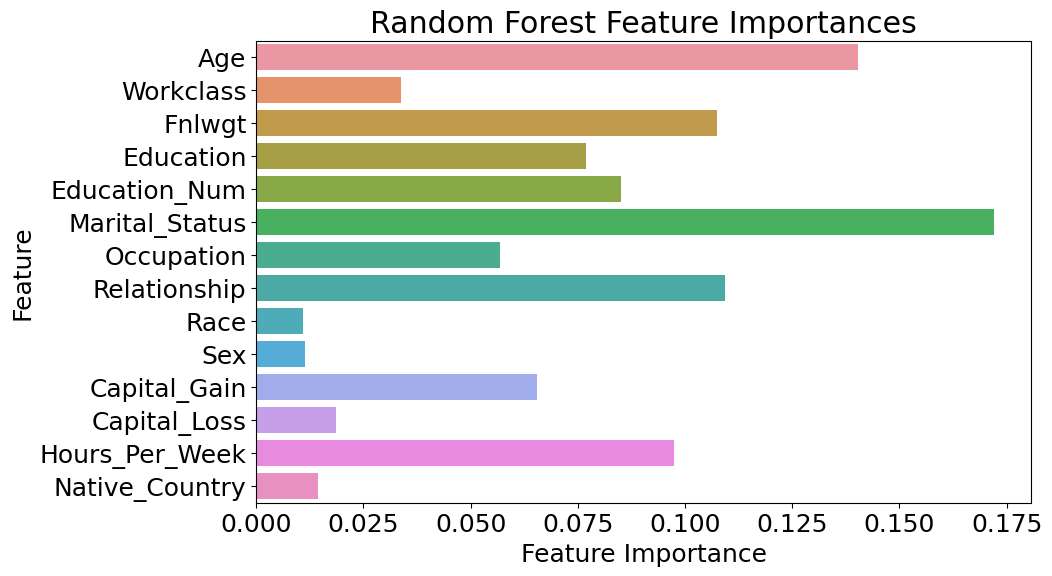

In [10]:
def plot_feature_importances(rf_classifier):
  # Get feature importances from the trained model
  feature_importances = rf_classifier.feature_importances_

  print(feature_importances, X_train.columns)
  # Create a bar plot to visualize feature importances
  plt.figure(figsize=(10, 6))
  sns.barplot(x=feature_importances, y=X_train.columns)
  plt.xlabel('Feature Importance')
  plt.ylabel('Feature')
  plt.title('Random Forest Feature Importances')
  plt.show()

plot_feature_importances(rf_classifier)

**2.2 Naive Bayes Model (Multinomial Naive Bayes for classification)**

In [11]:
from sklearn.naive_bayes import MultinomialNB

# Initialize the Multinomial Naive Bayes Classifier
nb_classifier = MultinomialNB()

# Record the start time
start_time = time.time()

# Train the model on the training data
nb_classifier.fit(X_train, y_train)

# Record the end time
end_time = time.time()

# Calculate the training time in seconds
training_time = end_time - start_time

# Print the training time
print(f"Training time of Multinomial Naive Bayes Classifier: {training_time:.2f} seconds")

# Make predictions on the test data
nb_predictions = nb_classifier.predict(X_test)

Training time of Multinomial Naive Bayes Classifier: 0.04 seconds


**Milestone:**
succefusslly trained and tested both models.

### 3 Model Evaluation

**3.1 Accuracy, recision, recall, f1-score and support**

In [12]:
from sklearn.metrics import accuracy_score, classification_report

# accuracy_score -> the set of labels predicted for a sample must *exactly* match the corresponding set of labels in y_true.

# Evaluate the model
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_report = classification_report(y_test, rf_predictions)

print("Random Forest Classifier Accuracy:", rf_accuracy)
print("Classification Report:\n", rf_report)

# Evaluate the model
nb_accuracy = accuracy_score(y_test, nb_predictions)
nb_report = classification_report(y_test, nb_predictions)

print("Multinomial Naive Bayes Classifier Accuracy:", nb_accuracy, "\n")
print("Classification Report:\n", nb_report)

Random Forest Classifier Accuracy: 0.8419630243842516
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.88      0.90     12435
           1       0.65      0.70      0.68      3846

    accuracy                           0.84     16281
   macro avg       0.78      0.79      0.79     16281
weighted avg       0.85      0.84      0.84     16281

Multinomial Naive Bayes Classifier Accuracy: 0.7849026472575394 

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.96      0.87     12435
           1       0.62      0.23      0.34      3846

    accuracy                           0.78     16281
   macro avg       0.71      0.59      0.60     16281
weighted avg       0.76      0.78      0.75     16281



**3.2 ROC and AUC**

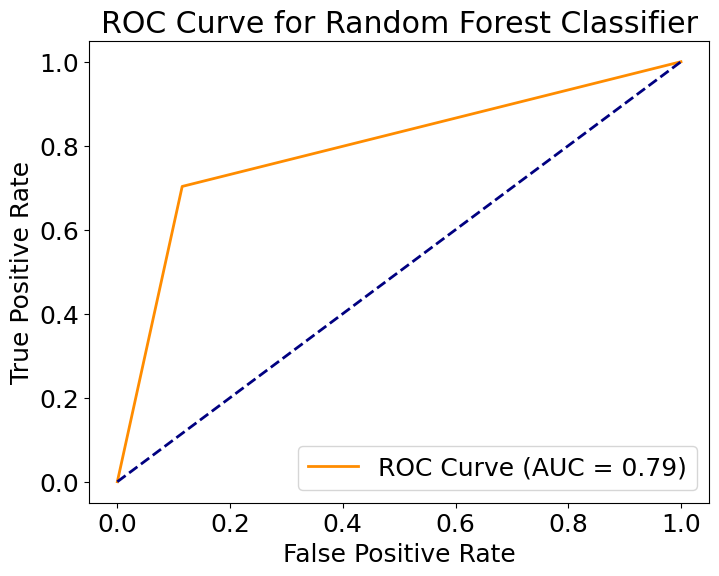

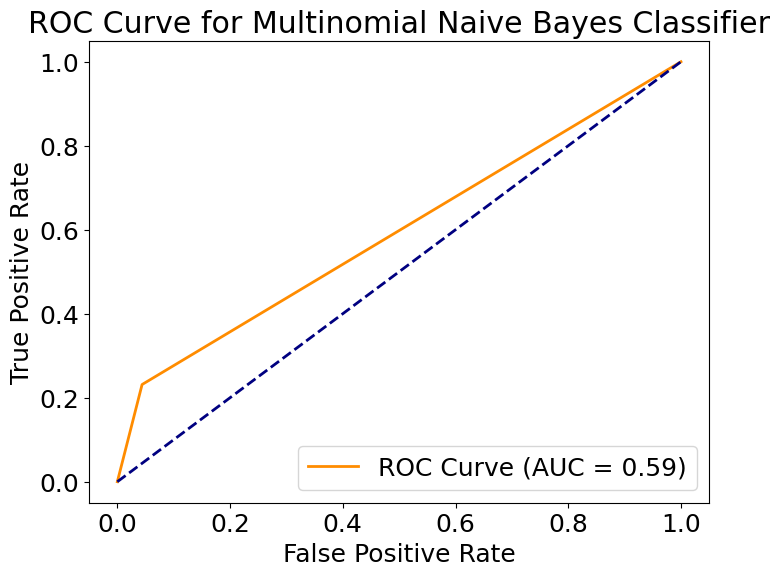

In [13]:
from sklearn.metrics import roc_curve, roc_auc_score
# import matplotlib.pyplot as plt

def plot_roc_curve(y_true, y_probs, model_name='Classifier'):
    """
    Plot the ROC curve for a classification model and calculate AUC.

    Parameters:
    - y_true: True labels (ground truth).
    - y_probs: Predicted probabilities for the positive class.
    - model_name: Name of the classification model (optional, default is 'Classifier').
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_probs)
    auc = roc_auc_score(y_true, y_probs)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc='lower right')
    plt.show()

plot_roc_curve(y_test, rf_predictions, "Random Forest Classifier")
plot_roc_curve(y_test, nb_predictions, "Multinomial Naive Bayes Classifier")

| Classifier                 | Accuracy | AUC  | Precision | Recall | F1-Score |
|----------------------------|----------|------|-----------|--------|----------|
| Random Forest Classifier   | 84.20%   | 0.79 | 91.00%    | 70.00% | 79.00%   |
| Multinomial Naive Bayes    | 78.49%   | 0.59 | 62.00%    | 23.00% | 34.00%   |

**Milestone:**
Based on these metrics, we can make the following observations:

1. The Random Forest Classifier has a higher overall accuracy compared to the Multinomial Naive Bayes Classifier.
2. For class 0 (<=50K), both classifiers have relatively good precision, recall, and F1-score.
3. For class 1 (>50K), the Random Forest Classifier outperforms the Multinomial Naive Bayes Classifier in terms of precision, recall, and F1-score.

**Conclusion:**
Overall, the Random Forest Classifier appears to be the better-performing model, especially for classifying the minority class (class 1). However, the choice of the best model depends on your specific goals and the trade-offs you're willing to make between precision and recall, among other factors.

### 4 Hyperparameter Tuning

**4.1.1 Random Forest Classification - RandomizedSearchCV**

Tuning time of Random Search: 196.44 seconds
[0.1109657  0.03063874 0.05542267 0.08490382 0.09880463 0.20929481
 0.04520593 0.13657692 0.00870588 0.01292807 0.07592708 0.02003061
 0.09863427 0.01196088] Index(['Age', 'Workclass', 'Fnlwgt', 'Education', 'Education_Num',
       'Marital_Status', 'Occupation', 'Relationship', 'Race', 'Sex',
       'Capital_Gain', 'Capital_Loss', 'Hours_Per_Week', 'Native_Country'],
      dtype='object')


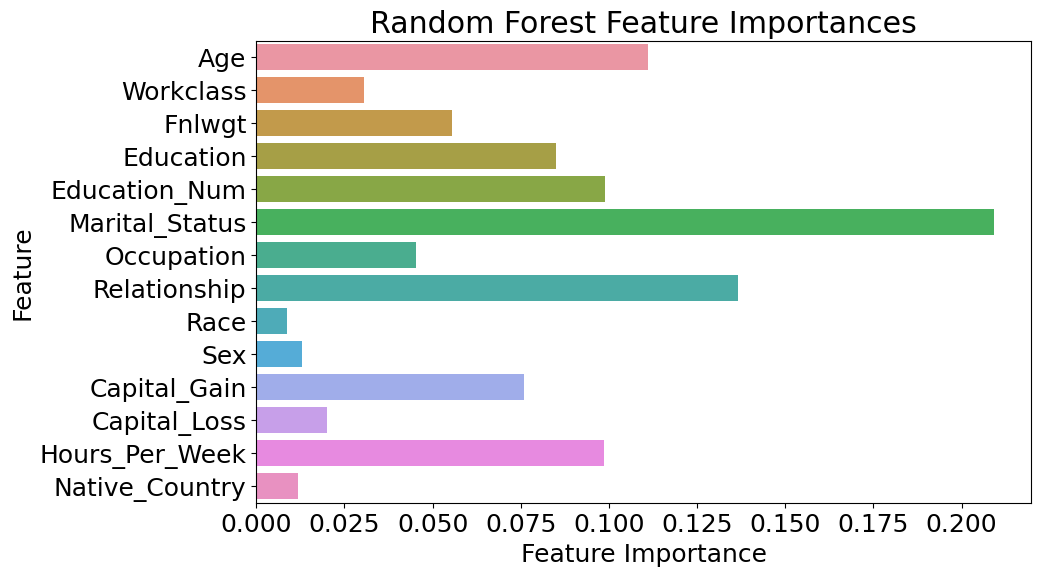

Random Forest Classifier Accuracy (after tuning): 0.8446041397948529
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.88      0.90     12435
           1       0.66      0.72      0.69      3846

    accuracy                           0.84     16281
   macro avg       0.78      0.80      0.79     16281
weighted avg       0.85      0.84      0.85     16281



In [14]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define a smaller parameter grid
param_dist = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(
    rf_classifier, param_distributions=param_dist, n_iter=10,
    cv=3, scoring='accuracy', n_jobs=-1, random_state=42
)

# Record the start time
start_time = time.time()

# Fit the random search to your data
random_search.fit(X_train, y_train)

# Record the end time
end_time = time.time()

# Calculate the training time in seconds
tuning_time = end_time - start_time

# Print the training time
print(f"Tuning time of Random Search: {tuning_time:.2f} seconds")

# Get the best parameters
best_params = random_search.best_params_

# Get the best model
best_rf_model = random_search.best_estimator_

# Evaluate the best model
rf_predictions = best_rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_report = classification_report(y_test, rf_predictions)

# print("Best Parameters:", best_params)
plot_feature_importances(best_rf_model)

print("Random Forest Classifier Accuracy (after tuning):", rf_accuracy)
print("Classification Report:\n", rf_report)

**4.1.2 Random Forest Classification - RandomizedSearchCV + Early Stop**

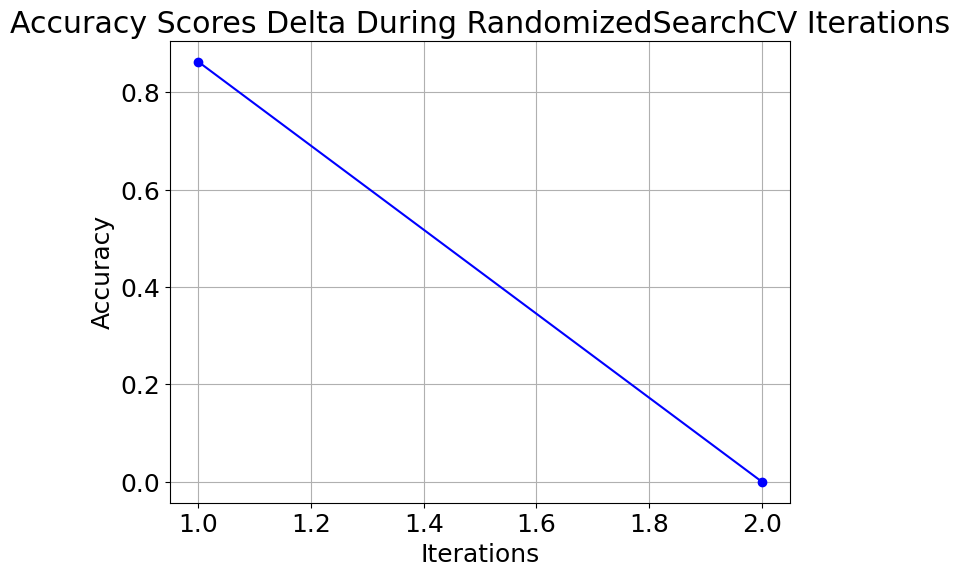

Tuning time of Random Search with Early Stop: 359.56 seconds
[0.1109657  0.03063874 0.05542267 0.08490382 0.09880463 0.20929481
 0.04520593 0.13657692 0.00870588 0.01292807 0.07592708 0.02003061
 0.09863427 0.01196088] Index(['Age', 'Workclass', 'Fnlwgt', 'Education', 'Education_Num',
       'Marital_Status', 'Occupation', 'Relationship', 'Race', 'Sex',
       'Capital_Gain', 'Capital_Loss', 'Hours_Per_Week', 'Native_Country'],
      dtype='object')


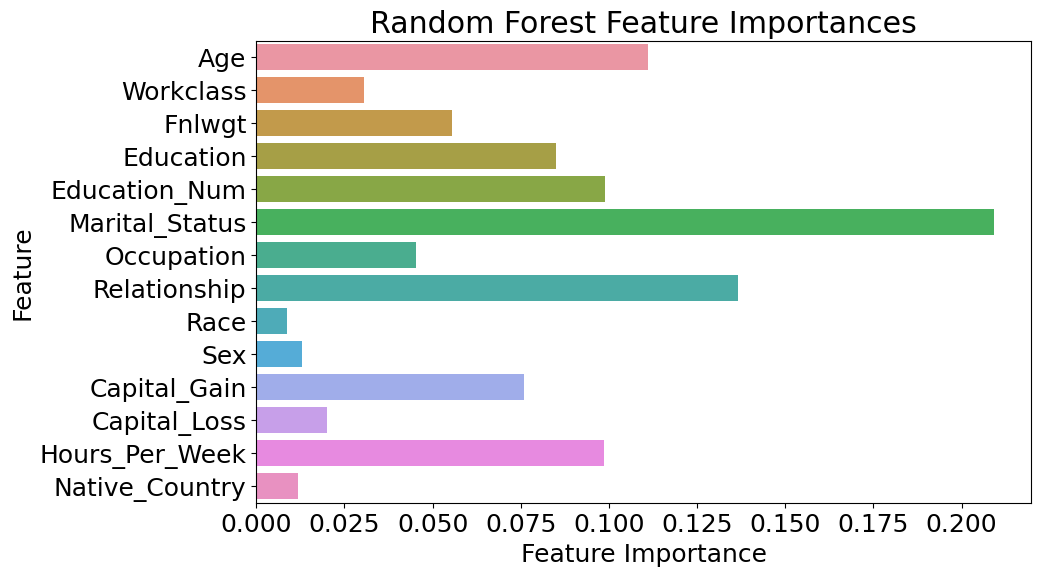

Random Forest Classifier Accuracy (after tuning): 0.8446041397948529
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.88      0.90     12435
           1       0.66      0.72      0.69      3846

    accuracy                           0.84     16281
   macro avg       0.78      0.80      0.79     16281
weighted avg       0.85      0.84      0.85     16281



In [15]:
# Define the stopping criterion tolerance
tol = 1e-10

# Initialize an empty list to store accuracy scores
accuracy_scores_delta = []

# Create a RandomizedSearchCV object with stopping criterion
random_search = RandomizedSearchCV(
    rf_classifier, param_distributions=param_dist, n_iter=10,
    cv=3, scoring='accuracy', n_jobs=-1, random_state=42
)

# Initialize variables to track the previous best accuracy and the change in accuracy
prev_best_accuracy = 0.0
delta_accuracy = float('inf')

# Record the start time
start_time = time.time()

while delta_accuracy > tol:
    # Fit the random search to your data
    random_search.fit(X_train, y_train)

    # Get the best accuracy from the current search
    current_best_accuracy = random_search.best_score_

    # Add the current accuracy score to the list
    # accuracy_scores.append(current_best_accuracy)

    # Calculate the change in accuracy
    delta_accuracy = abs(current_best_accuracy - prev_best_accuracy)

    # Add the current delta to the list
    accuracy_scores_delta.append(delta_accuracy)

    # Update the previous best accuracy for the next iteration
    prev_best_accuracy = current_best_accuracy

# Record the end time
end_time = time.time()

# Calculate the training time in seconds
tuning_time = end_time - start_time

# Plot the accuracy scores
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(accuracy_scores_delta) + 1), accuracy_scores_delta, marker='o', linestyle='-', color='b')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy Scores Delta During RandomizedSearchCV Iterations')
plt.grid(True)
plt.show()

# Print the training time
print(f"Tuning time of Random Search with Early Stop: {tuning_time:.2f} seconds")

# Get the best parameters and best model after the search stops
best_params = random_search.best_params_
best_rf_model = random_search.best_estimator_

# Evaluate the best model
rf_predictions = best_rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_report = classification_report(y_test, rf_predictions)

# print("Best Parameters:", best_params)
plot_feature_importances(best_rf_model)

print("Random Forest Classifier Accuracy (after tuning):", rf_accuracy)
print("Classification Report:\n", rf_report)

**4.2 Naive Bayes Model - cross-validation**

In [16]:
from sklearn.model_selection import cross_val_score

alphas = [0.1, 0.5, 1.0, 1.5, 2.0]

best_alpha = None
best_score = -1

# Record the start time
start_time = time.time()

for alpha in alphas:
    nb_classifier = MultinomialNB(alpha=alpha)
    scores = cross_val_score(nb_classifier, X_train, y_train, cv=3, scoring='accuracy')
    mean_score = scores.mean()

    if mean_score > best_score:
        best_score = mean_score
        best_alpha = alpha

# Train the final model with the best alpha value
best_nb_classifier = MultinomialNB(alpha=best_alpha)
best_nb_classifier.fit(X_train, y_train)

# Record the end time
end_time = time.time()

# Calculate the training time in seconds
tuning_time = end_time - start_time

# Print the training time
print(f"Tuning time of Best Alpha: {tuning_time:.2f} seconds")

# Make predictions and evaluate
nb_predictions = best_nb_classifier.predict(X_test)
nb_accuracy = accuracy_score(y_test, nb_predictions)
nb_report = classification_report(y_test, nb_predictions)

print("Best Alpha:", best_alpha)
print("Multinomial Naive Bayes Classifier Accuracy (after tuning):", nb_accuracy)
print("Classification Report:\n", nb_report)

Tuning time of Best Alpha: 0.47 seconds
Best Alpha: 0.1
Multinomial Naive Bayes Classifier Accuracy (after tuning): 0.7849026472575394
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.96      0.87     12435
           1       0.62      0.23      0.34      3846

    accuracy                           0.78     16281
   macro avg       0.71      0.59      0.60     16281
weighted avg       0.76      0.78      0.75     16281



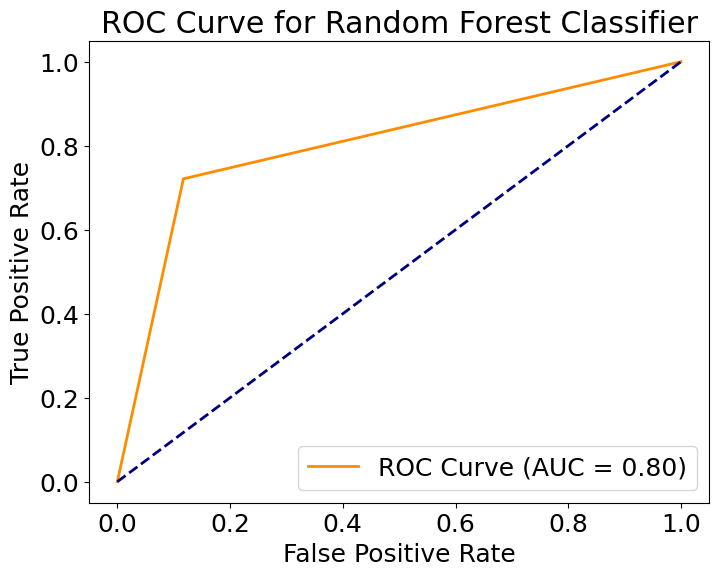

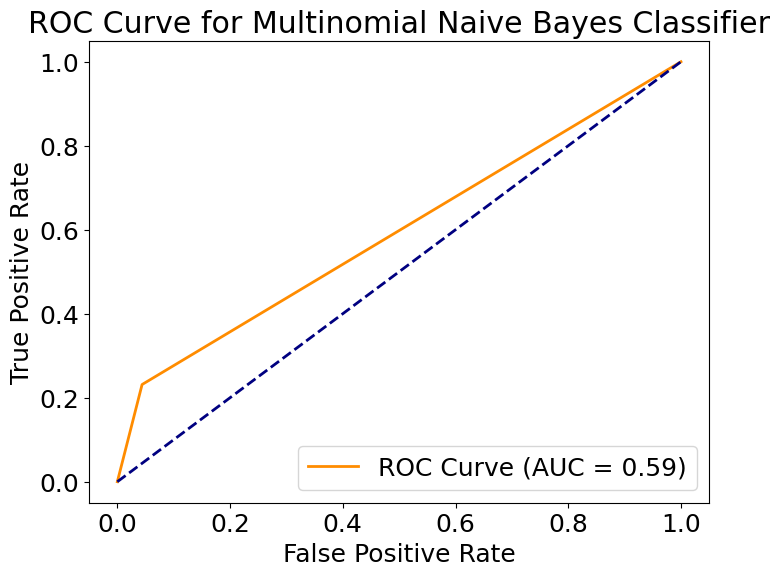

In [17]:
plot_roc_curve(y_test, rf_predictions, "Random Forest Classifier")
plot_roc_curve(y_test, nb_predictions, "Multinomial Naive Bayes Classifier")

### Reference

* [Census Income Project Using Python](https://medium.com/@lokeshbisen989/census-income-project-using-python-8f8d33a5942d)
